In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
forecast_days = 28
days_ahead = 1

shift_days = days_ahead - 1

start_test_date = 1914

# Load data

In [5]:
from src.data_prep import DataPrep
import random

random.seed(42)

data_prep = DataPrep('./data', sample=50)

train_df = data_prep.parse_data(start_test_date, train=True)

test_df = data_prep.parse_data(start_test_date, train=False)

# Create features

In [ ]:
from src.feature_transformer import FeatureTransformer

ft = FeatureTransformer(shift_days)

train_df = ft.calculate_timebase_features(train_df)
X_train = ft.fit_transform(train_df)

ft.save_data(X_train, train_df['sales'], 'train')

test_df = ft.calculate_timebase_features(test_df)
X_test = ft.transform(test_df)

ft.save_data(X_test, test_df['sales'], 'test')


# Run cross validation

In [ ]:
from src.cross_validator import CrossValidator
import numpy as np

cv = CrossValidator(n_splits=1, test_size=28)
cv.grid_search(X_train, train_df['sales'], train_df)[['params', 'mean_test_score', 'rank_test_score']]

# Run model

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from joblib import dump, load

import pandas as pd

import numpy as np

# Best estimator and params according to the cross_validation
lgbm = LGBMRegressor(n_estimators=100)

lgbm.fit(X_train, np.array(train_df['sales']))

dump(lgbm, 'lgbm_100_estimators.joblib') 

train_df['pred'] = lgbm.predict(X_train)
test_df['pred_test'] = lgbm.predict(X_test)

print(cv.rmsse(actual=train_df['sales'], 
         predicted=train_df['pred']))

print(cv.rmsse(actual=test_df['sales'], 
               predicted=test_df['pred_test']))

X_total = pd.concat([train_df, test_df])

# Plots

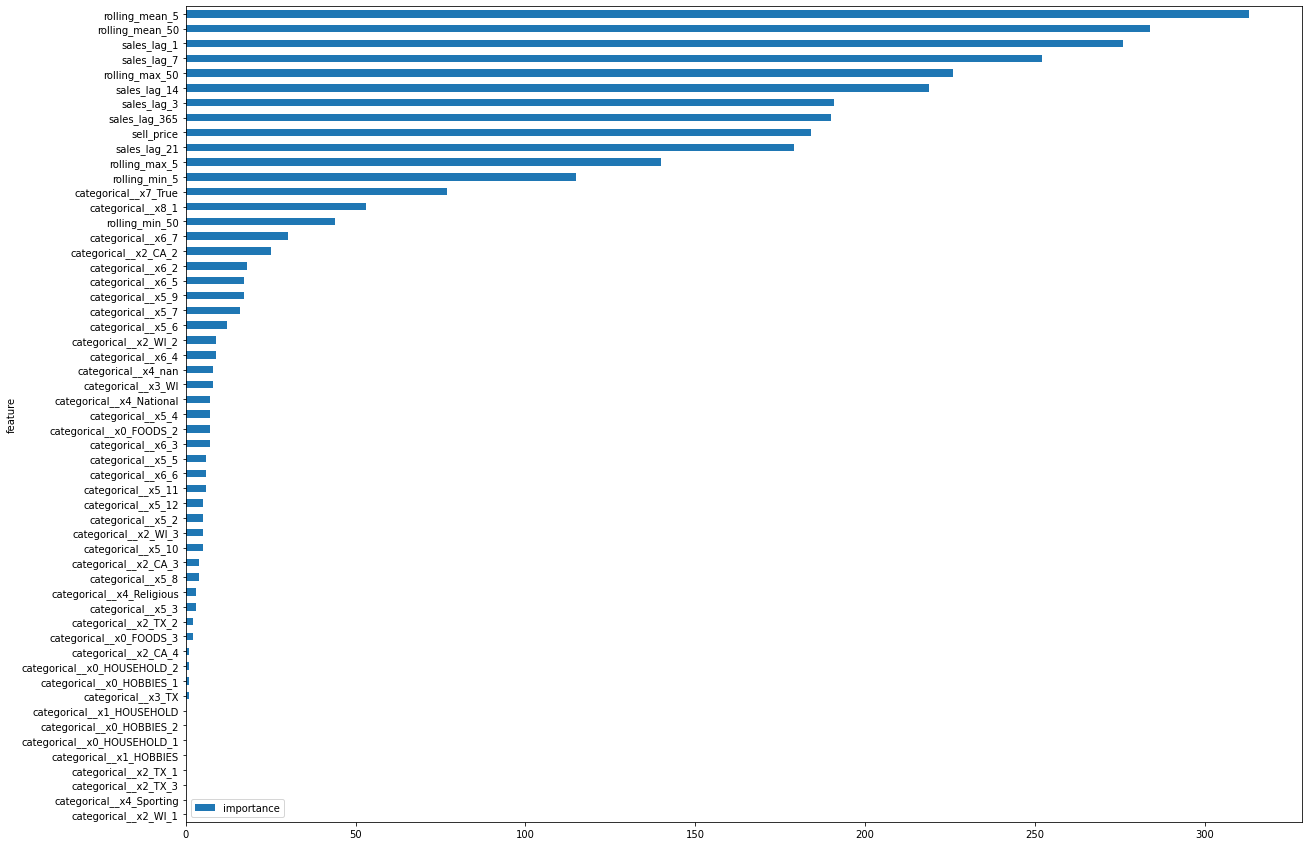

In [12]:
from src.visuals import Visuals

vis = Visuals()

vis.plot_feature_importances(lgbm, ft.feature_transformer.get_feature_names())

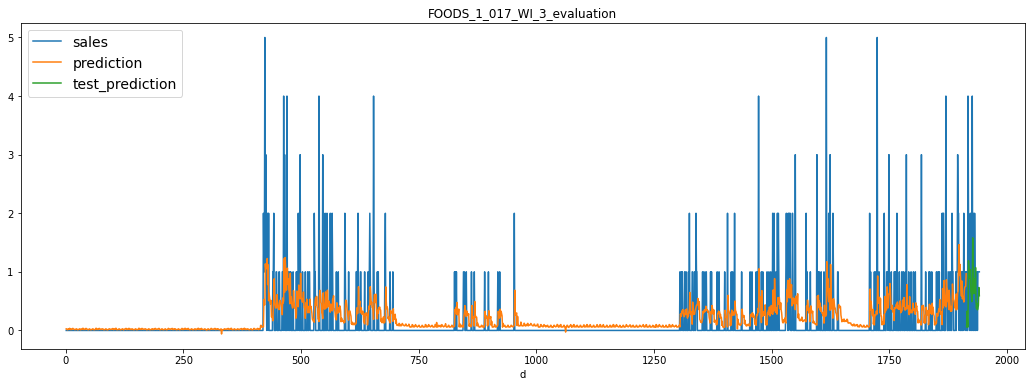

In [13]:
vis.plot_series(X_total, 1)

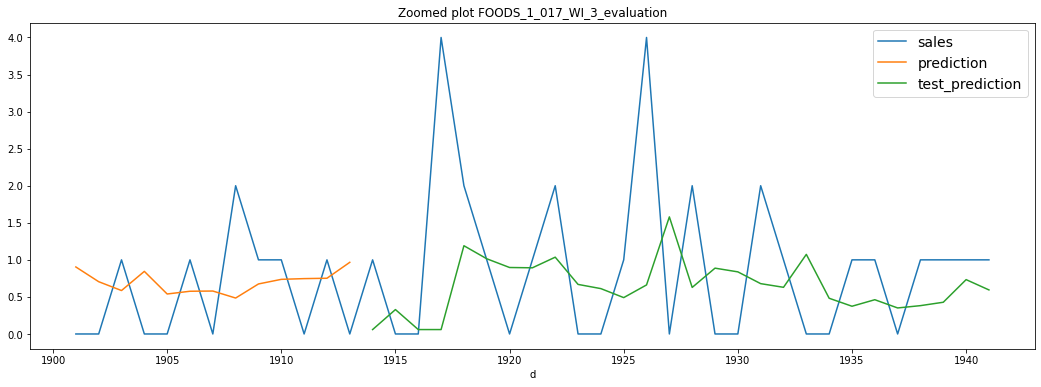

In [11]:
vis.plot_series_zoomed(X_total, 1)